In [102]:
from scipy.io import loadmat
import pandas as pd
from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:4326","EPSG:3413")


## load all the matlab files and save them as CSV files instead. 

First the accumulation radar file. 

In [103]:
acc= loadmat('accumulation_results.mat')

x,y = transformer.transform(acc['accrad'][0][0][2][:,0],acc['accrad'][0][0][2][:,1])
accrad = pd.DataFrame({'dist': acc['accrad'][0][0][0].ravel(),
                       'accum': acc['accrad'][0][0][1].ravel(),
                       'lat': acc['accrad'][0][0][2][:,0],
                       'lon': acc['accrad'][0][0][2][:,1],
                       'x': x, 'y': y
                       })
accrad.to_csv('acc_rad.csv',index=False)

Then the snow radar file....

In [104]:
x,y = transformer.transform(acc['snowrad'][0][0][2][:,0],acc['snowrad'][0][0][2][:,1])
snowrad = pd.DataFrame({'dist': acc['snowrad'][0][0][0].ravel(),
                       'accum': acc['snowrad'][0][0][1].ravel(),
                       'lat': acc['snowrad'][0][0][2][:,0],
                       'lon': acc['snowrad'][0][0][2][:,1],
                       'x': x, 'y': y
                       })
snowrad.to_csv('snow_rad.csv',index=False)

Then the density file. That is an image - lets save that as a netcdf so that it is easy to read with xarray.

In [105]:
import xarray as xr
dens = loadmat('density_data.mat')

z = dens['depth'].ravel()*1.0
x = dens['offset_along_line'].ravel()
rho = dens['firn_density']

density = xr.DataArray(
    data=rho,
    dims=["depth", "offset"],
    coords=dict(
        offset=(["offset"], x),
        depth=(["depth"], z),
    ),
    attrs=dict(
        description="Density along a seismic profile near EastGRIP from Rivermann et al.",
        units="kg/m3",
    ),
)
density.to_netcdf('density.nc')


Then the geophone location file. 

In [106]:
g = loadmat('geophones_location.mat')
offset = g['gph_offest'].ravel()
gx = g['gph_x'].ravel()
gy = g['gph_y'].ravel()
gz = g['gph_z'].ravel()


lat,lon = transformer.transform(gx,gy,direction='inverse')

gloc = pd.DataFrame({'offset':offset,'x':gx,'y':gy,'z':gz,'lat':lat,'lon':lon})

gloc.to_csv('geophones_location.csv',index=False)


## investigating offsets.

Now lets plot some of the data. Especially try to figure out if there is something wrong with the offset in the density image. It seems like the density "offset" should correspond to the "offset" in the geophone locations file. But there is an offset in plots. Lets see if we can figure out what the issue is. 

In [107]:
#Try to do some tests to see of
x0,y0 = gloc.x[0],gloc.y[0]
distance_from_0 = np.sqrt((gloc.x-x0)**2+(gloc.y-y0)**2)
print(f'Lratio1={(distance_from_0.iloc[-1]-distance_from_0.iloc[0])/(gloc.offset.iloc[-1]-gloc.offset.iloc[0]):.3f}')

dL = np.sqrt((np.diff(gloc.x.values)**2+(np.diff(gloc.y.values))**2))
Lsum = np.sum(dL)
print(f'Lratio2={Lsum/(gloc.offset.iloc[-1]-gloc.offset.iloc[0]):.3f}')


Lratio1=0.999
Lratio2=0.999


As the above line length ratios are one then we know this is close to how the "offset" in the geophone locations were calculated. They are just distance along line. 

The radar line dist column are calculated as the distance from the first location in the geophone file. We can calculate an alternative radar_offset column for the geophone locations like this.

In [120]:
import numpy as np
x0,y0 = snowrad.x[0],snowrad.y[0]
gloc['radar_offset'] = np.sqrt((gloc.x-x0)**2+(gloc.y-y0)**2) 
print(f'Lratio radar_offset/geophone_offset={(gloc.radar_offset.iloc[-1]-gloc.radar_offset.iloc[0])/(gloc.offset.iloc[-1]-gloc.offset.iloc[0]):.3f}')

Lratio radar_offset/geophone_offset=0.985


We want to interpolate the know the elevation along the geophone line. So we need to load arcticdem and interpolate into that. We use a custom fast interpolation function for that. 

In [121]:

import rioxarray as rio
#surf = rio.open_rasterio(r'C:\Users\ag\HugeData\bedmachine5\bedmachine-v5-surface.tif')
surf = rio.open_rasterio(r'C:\Users\ag\HugeData\ArcticDEM\egrip\egrip-merged30mres.tif')
def interpgrid(x, y, a, xi, yi):
    """ 2d linear interpolation
    - vectorized version.
    - with bounds checking.

    - does not check if input sizes are compatible.
    - assumes numpy inputs

    """

    xi = (xi - x[0]) / (x[1] - x[0])
    yi = (yi - y[0]) / (y[1] - y[0])
    Ny, Nx = a.shape

    inbounds = (xi>=0)&(xi<Nx)&(yi>=0)&(yi<Ny) #excludes points where xi=Ny
    ai = np.full(xi.shape,np.nan)

    xi = xi[inbounds]
    yi = yi[inbounds]

    x = xi.astype(int)
    y = yi.astype(int)
    xn = x + 1
    yn = y + 1

    a00 = a[y, x]
    a01 = a[y, xn]
    a10 = a[yn, x]
    a11 = a[yn, xn]
    xt = xi - x
    yt = yi - y
    a0 = a00 * (1 - xt) + a01 * xt
    a1 = a10 * (1 - xt) + a11 * xt
    ai[inbounds] = a0 * (1 - yt) + a1 * yt

    return ai
zz=interpgrid(surf.x.values,surf.y.values,surf.data.squeeze(),gloc.x,gloc.y)
gloc['z_arcticdem']=zz

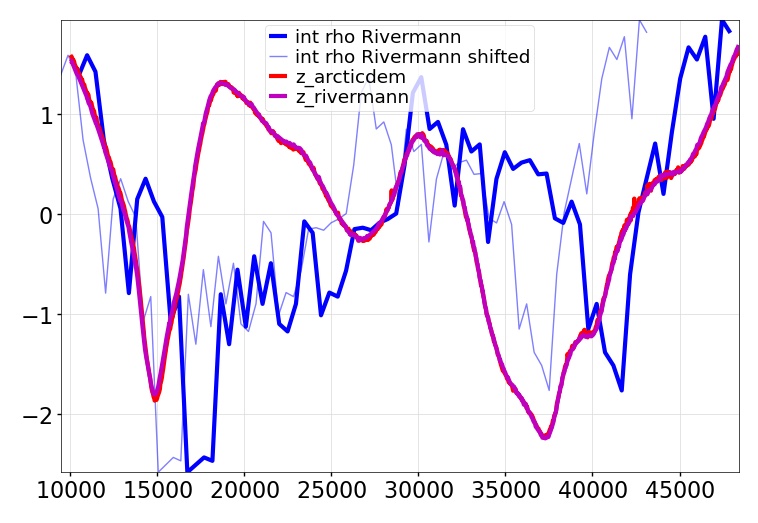

In [126]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore


radar_offset = np.interp(da.offset, gloc.offset.values, gloc.radar_offset.values)
alternative_offset = density.offset*.9
plt.plot(density.offset,-zscore(density.integrate('depth')),'b',label='int rho Rivermann')
#plt.plot(da.offset,zscore(da[10,:]),':')
plt.plot(alternative_offset,-zscore(density.integrate('depth')),'b',alpha=0.5,lw=0.5,label='int rho Rivermann shifted')
plt.plot(gloc.offset,zscore(gloc.z_arcticdem),'r',label='z_arcticdem')
plt.plot(gloc.offset,zscore(gloc.z),'m', label='z_rivermann')
#plt.plot(accrad.dist,zscore(accrad.accum),'g')
#plt.plot(snowrad.dist,zscore(snowrad.accum))

plt.legend()

